## Import necessary modules 

In [1]:
# Load necessary packages

import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import missingno as msn
from shapely.ops import nearest_points

import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline

# Problems

## 1. Cleanup

A sample dataset of request logs is given in data/DataSample.csv. We consider records that have identical geoinfo and timest as suspicious. Please clean up the sample dataset by filtering out those suspicious request records.

In [2]:
## Load data sample using pandas

data_sample = pd.read_csv("data\DataSample.csv")
data_sample.head()

_ID                   TimeSt Country Province       City  Latitude  \
0  4516516  2017-06-21 00:00:00.143      CA       ON   Waterloo  43.49347   
1  4516547  2017-06-21 18:00:00.193      CA       ON     London  42.93990   
2  4516550  2017-06-21 15:00:00.287      CA       ON     Guelph  43.57760   
3  4516600  2017-06-21 15:00:00.307      CA       ON  Stratford  43.37160   
4  4516613  2017-06-21 15:00:00.497      CA       ON  Stratford  43.37160   

   Longitude  
0  -80.49123  
1  -81.27090  
2  -80.22010  
3  -80.97730  
4  -80.97730

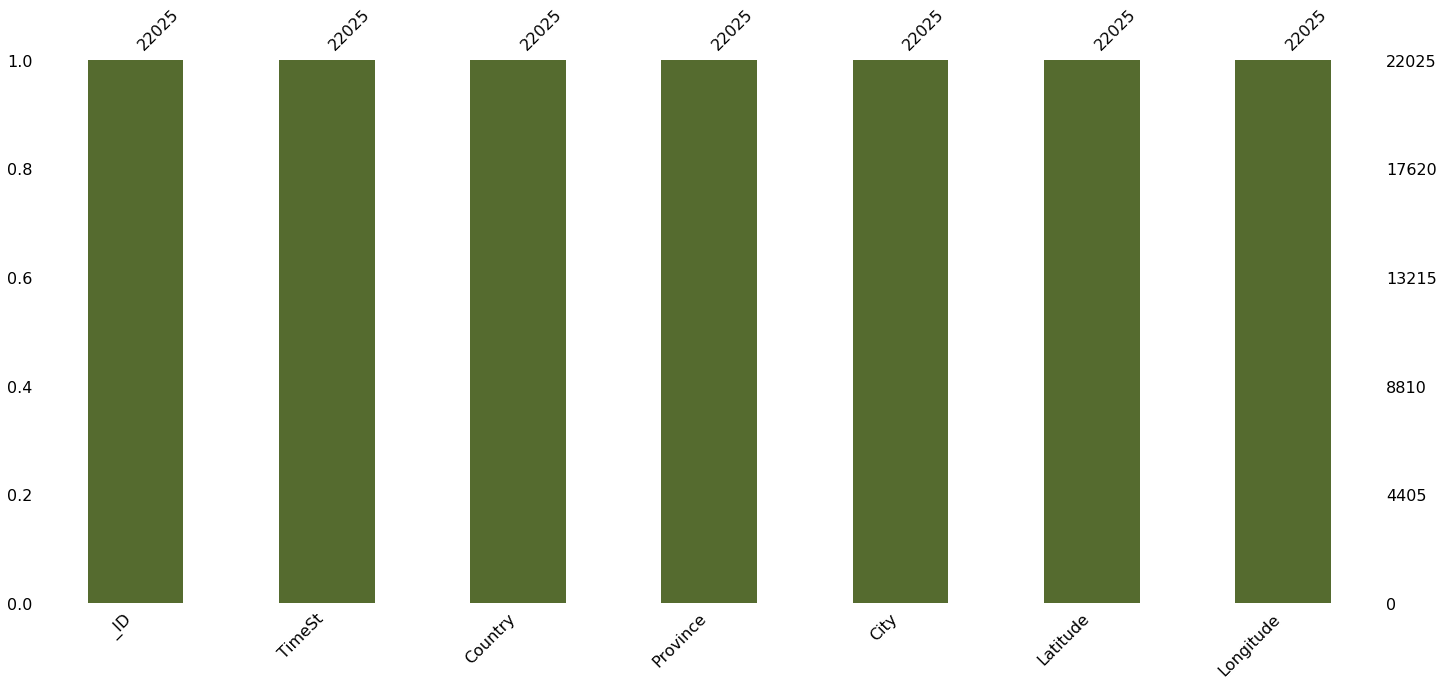

In [3]:
## Check for missing values (entries)
msn.bar(data_sample, color='darkolivegreen');

In [4]:
# Combining Lattitude and Longitude to create data sample coordinates:

Longitude = [(0-i) if i > 0 else i for i in data_sample['Longitude']]
data_sample['Longitude'] = Longitude

data_sample['coord_data'] = data_sample[['Longitude', 'Latitude']].values.tolist()
data_sample.head()

_ID                   TimeSt Country Province       City  Latitude  \
0  4516516  2017-06-21 00:00:00.143      CA       ON   Waterloo  43.49347   
1  4516547  2017-06-21 18:00:00.193      CA       ON     London  42.93990   
2  4516550  2017-06-21 15:00:00.287      CA       ON     Guelph  43.57760   
3  4516600  2017-06-21 15:00:00.307      CA       ON  Stratford  43.37160   
4  4516613  2017-06-21 15:00:00.497      CA       ON  Stratford  43.37160   

   Longitude             coord_data  
0  -80.49123  [-80.49123, 43.49347]  
1  -81.27090    [-81.2709, 42.9399]  
2  -80.22010    [-80.2201, 43.5776]  
3  -80.97730    [-80.9773, 43.3716]  
4  -80.97730    [-80.9773, 43.3716]

In [5]:
# Change the coordinates to a geoPoint

data_sample['coord_data'] = data_sample['coord_data'].apply(Point)
data_sample.head()

_ID                   TimeSt Country Province       City  Latitude  \
0  4516516  2017-06-21 00:00:00.143      CA       ON   Waterloo  43.49347   
1  4516547  2017-06-21 18:00:00.193      CA       ON     London  42.93990   
2  4516550  2017-06-21 15:00:00.287      CA       ON     Guelph  43.57760   
3  4516600  2017-06-21 15:00:00.307      CA       ON  Stratford  43.37160   
4  4516613  2017-06-21 15:00:00.497      CA       ON  Stratford  43.37160   

   Longitude                  coord_data  
0  -80.49123  POINT (-80.49123 43.49347)  
1  -81.27090    POINT (-81.2709 42.9399)  
2  -80.22010    POINT (-80.2201 43.5776)  
3  -80.97730    POINT (-80.9773 43.3716)  
4  -80.97730    POINT (-80.9773 43.3716)

In [6]:
data_sample.shape

(22025, 8)

In [7]:
# Convert the dataframe to geodf and drop_duplicates in TimeSt and Geoinfo

data_sample = gpd.GeoDataFrame(data_sample, geometry='coord_data')
data_sample = data_sample.drop_duplicates(subset = [' TimeSt','coord_data'])
data_sample.head()

_ID                   TimeSt Country Province       City  Latitude  \
0  4516516  2017-06-21 00:00:00.143      CA       ON   Waterloo  43.49347   
1  4516547  2017-06-21 18:00:00.193      CA       ON     London  42.93990   
2  4516550  2017-06-21 15:00:00.287      CA       ON     Guelph  43.57760   
3  4516600  2017-06-21 15:00:00.307      CA       ON  Stratford  43.37160   
4  4516613  2017-06-21 15:00:00.497      CA       ON  Stratford  43.37160   

   Longitude                  coord_data  
0  -80.49123  POINT (-80.49123 43.49347)  
1  -81.27090  POINT (-81.27090 42.93990)  
2  -80.22010  POINT (-80.22010 43.57760)  
3  -80.97730  POINT (-80.97730 43.37160)  
4  -80.97730  POINT (-80.97730 43.37160)

In [8]:
## Define and assign coordinate reference system

data_sample.crs = {'init' : 'epsg:4326'}
data_sample = data_sample.to_crs({'init': 'epsg:3395'})

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## 2. Label

Assign each request (from data/DataSample.csv) to the closest (i.e. minimum distance) POI (from data/POIList.csv).

Note: a POI is a geographical Point of Interest.

In [9]:
## Load the POI Data and clean it up

poi = pd.read_csv("data\POIList.csv")
poi.head()

POIID   Latitude   Longitude
0  POI1  53.546167 -113.485734
1  POI2  53.546167 -113.485734
2  POI3  45.521629  -73.566024
3  POI4  45.224830  -63.232729

In [10]:
# Combining Lattitude and Longitude to create POI coordinates:

poi['coord_POI'] = poi[['Longitude', 'Latitude']].values.tolist()
poi.head()

POIID   Latitude   Longitude                                  coord_POI
0  POI1  53.546167 -113.485734  [-113.48573400000001, 53.546167000000004]
1  POI2  53.546167 -113.485734  [-113.48573400000001, 53.546167000000004]
2  POI3  45.521629  -73.566024                    [-73.566024, 45.521629]
3  POI4  45.224830  -63.232729            [-63.232729000000006, 45.22483]

In [11]:
# Change the coordinates to a geoPoint

poi['coord_POI'] = poi['coord_POI'].apply(Point)
poi.head()

POIID   Latitude   Longitude                            coord_POI
0  POI1  53.546167 -113.485734        POINT (-113.485734 53.546167)
1  POI2  53.546167 -113.485734        POINT (-113.485734 53.546167)
2  POI3  45.521629  -73.566024         POINT (-73.566024 45.521629)
3  POI4  45.224830  -63.232729  POINT (-63.23272900000001 45.22483)

In [12]:
# Convert the df_POI to geodf
poi = gpd.GeoDataFrame(poi, geometry='coord_POI')
poi = poi.drop_duplicates(subset = 'coord_POI')
poi.head()

POIID   Latitude   Longitude                    coord_POI
0  POI1  53.546167 -113.485734  POINT (-113.48573 53.54617)
2  POI3  45.521629  -73.566024   POINT (-73.56602 45.52163)
3  POI4  45.224830  -63.232729   POINT (-63.23273 45.22483)

In [13]:
## Define and assign coordinate reference system

poi.crs = {'init' : 'epsg:4326'}
poi = poi.to_crs({'init': 'epsg:3395'})

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [14]:
## Assign each request to the closest POI

pts = poi.coord_POI.unary_union
def near(point, pts=pts):
    nearest = poi.coord_POI == nearest_points(point, pts)[1]
    return poi[nearest].POIID.get_values()[0]

data_sample['POIID'] = data_sample.apply(lambda row: near(row.coord_data), axis=1)

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
c:\users\malik\appdata\local\programs\python\python37\lib\site-packa

In [15]:
## Combine the data to get corresponging geometry (coordinates)

data = data_sample.merge(poi, on = 'POIID')

In [16]:
data['Distance']=data['coord_data'].distance(gpd.GeoSeries(data['coord_POI']))

## 3. Analysis

    1. For each POI, calculate the average and standard deviation of the distance between the POI to each of its assigned requests.
    2. At each POI, draw a circle (with the center at the POI) that includes all of its assigned requests. Calculate the radius and density (requests/area) for each POI.

In [17]:
## Calculating the average distance using groupby method and the standard deviation using groupby method

average_distance = data.groupby('POIID')['Distance'].mean()
standard_deviation = data.groupby(by='POIID')['Distance'].agg(np.std)

print('The average distance between POI to each requests in metres are: ', average_distance)
print('\n')
print('The standard deviation of the distance between POI to each requests in metres are: ', standard_deviation)

The average distance between POI to each requests in metres are:  POIID
POI1    480488.621107
POI3    640797.960368
POI4    423865.589179
Name: Distance, dtype: float64


The standard deviation of the distance between POI to each requests in metres are:  POIID
POI1    480232.389756
POI3    327982.681816
POI4    613736.341551
Name: Distance, dtype: float64


In [18]:
## Calculating the radius and area using a buffer equals to the average distance

Area = []
for points, pois in zip(data['coord_POI'], data['POIID']):
    if pois == 'POI1':
        Area.append(points.buffer(average_distance['POI1']).area)
    elif pois == 'POI3':
        Area.append(points.buffer(average_distance['POI3']).area)
    else:
        Area.append(points.buffer(average_distance['POI4']).area)
        
Area = np.array(Area)
Radius = (Area/math.pi)**0.5

data['Area'] = Area
data['Radius'] = Radius

requests = data.groupby('POIID')['Area'].count()
mean_radius =  data.groupby('POIID')['Radius'].mean()
mean_area =  data.groupby('POIID')['Area'].mean()

In [19]:
print('Radius for each POI in metres is: ', mean_radius)
print('\n')
print('Density for each POI is given requests/m^2 as: ', requests/mean_area)

Radius for each POI in metres is:  POIID
POI1    480102.728209
POI3    640283.318873
POI4    423525.171709
Name: Radius, dtype: float64


Density for each POI is given requests/m^2 as:  POIID
POI1    1.340224e-08
POI3    7.622274e-09
POI4    8.464670e-10
Name: Area, dtype: float64


## 4. Data Science/Engineering Tracks

### 4a. Model

    1. To visualize the popularity of each POI, they need to be mapped to a scale that ranges from -10 to 10. Please 
        provide a mathematical model to implement this, taking into consideration of extreme cases and outliers. 
        Aim to be more sensitive around the average and provide as much visual differentiability as possible.
        
    2. Bonus: Try to come up with some reasonable hypotheses regarding POIs, state all assumptions, testing steps 
              and conclusions. Include this as a text file (with a name bonus) in your final submission.
    
### 4b. Pipeline Dependency

We use a modular design on all of our data analysis tasks. To get to a final product, we organize steps using a data pipeline. One task may require the output of one or multiple other tasks to run successfully. This creates dependencies between tasks.

We also require the pipeline to be flexible. This means a new task may enter a running pipeline anytime that may not have the tasks' dependencies satisfied. In this event, we may have a set of tasks already running or completed in the pipeline, and we will need to map out which tasks are prerequisites for the newest task so the pipeline can execute them in the correct order. For optimal pipeline execution, when we map out the necessary tasks required to execute the new task, we want to avoid scheduling tasks that have already been executed.

If we treat each task as a node and the dependencies between a pair of tasks as directed edges, we can construct a DAG (Wiki: Directed Acyclic Graph).

Consider the following scenario. At a certain stage of our data processing, we have a set of tasks (starting tasks) that we know all its prerequisite task has been executed, and we wish to reach to a later goal task. We need to map out a path that indicates the order of executions on tasks that finally leads to the goal task. We are looking for a solution that satisfies both necessity and sufficiency -- if a task is not a prerequisite task of goal, or its task is a prerequisite task for starting tasks (already been executed), then it shouldn't be included in the path. The path needs to follow a correct topological ordering of the DAG, hence a task needs to be placed behind all its necessary prerequisite tasks in the path.

Note: A starting task should be included in the path, if and only if it's a prerequisite of the goal task

## 4a(1) I don't really understand this question... I will be willing to solve it if I get clarification on it.

## 4a(2)

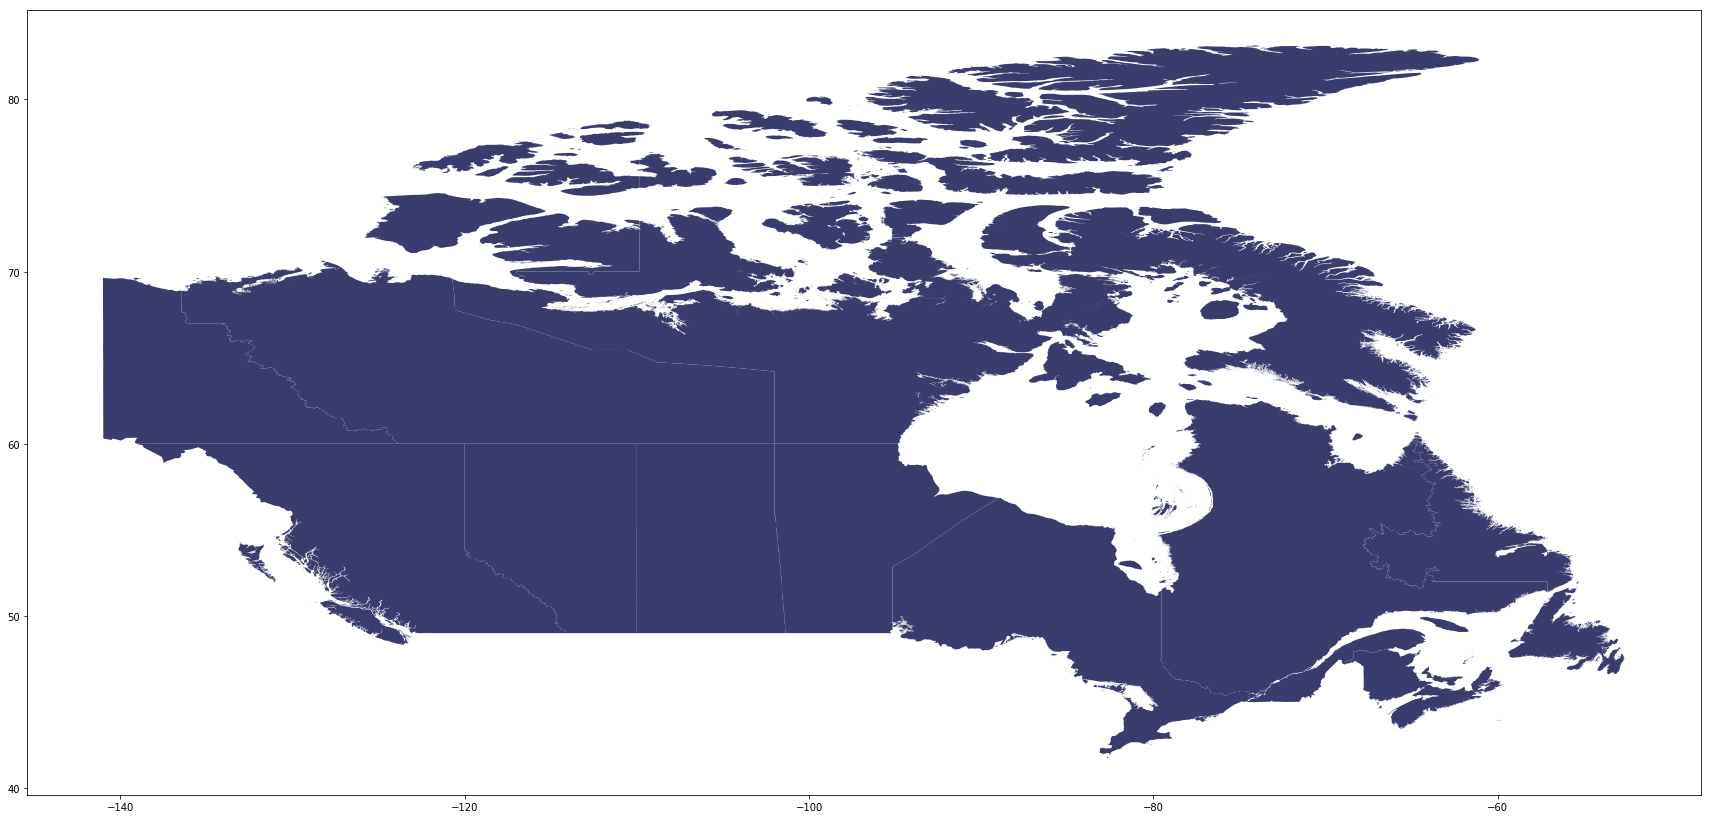

In [20]:
## 4a(2): Included as text files.

### Get Canada map data to see where the POIs are and also the requests

country = gpd.read_file("data\gpr_000b11a_e.shp")
country.plot(figsize=(30,20), color='#3B3C6E')

In [21]:
## Change the coordinate reference systems

data_sample.crs = {'init' : 'epsg:3395'}
data_sample = data_sample.to_crs({'init': 'epsg:4326'})

poi.crs = {'init' : 'epsg:3395'}
poi = poi.to_crs({'init': 'epsg:4326'})

c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
c:\users\malik\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


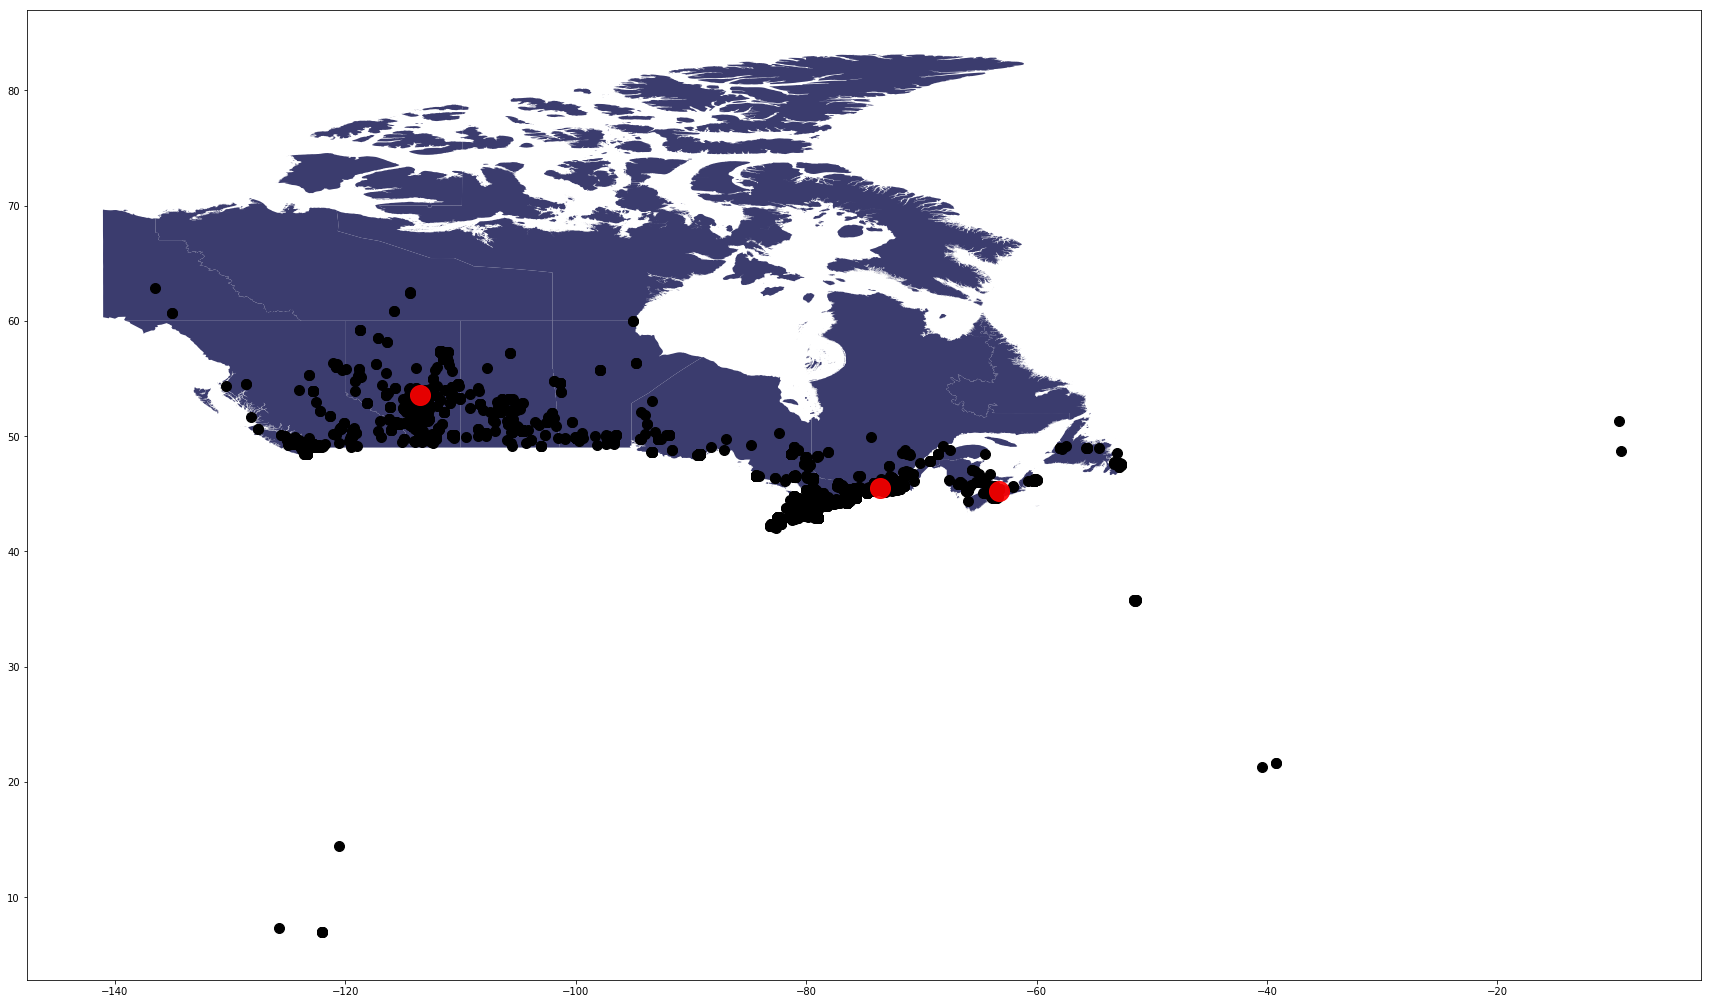

In [22]:
# Plotting to see the POIs overlay the Canada map:
fig, ax = plt.subplots(1, figsize=(30,20))
base = country.plot(ax=ax, color='#3B3C6E')

# plotting the position on top with red color to stand out:
data_sample.plot(ax=base, color='black', marker="o", markersize=100);
ax.scatter(poi.Longitude, poi.Latitude, zorder=1, alpha=0.9, c='r',s=400);

## 4b: Pipeline dependency

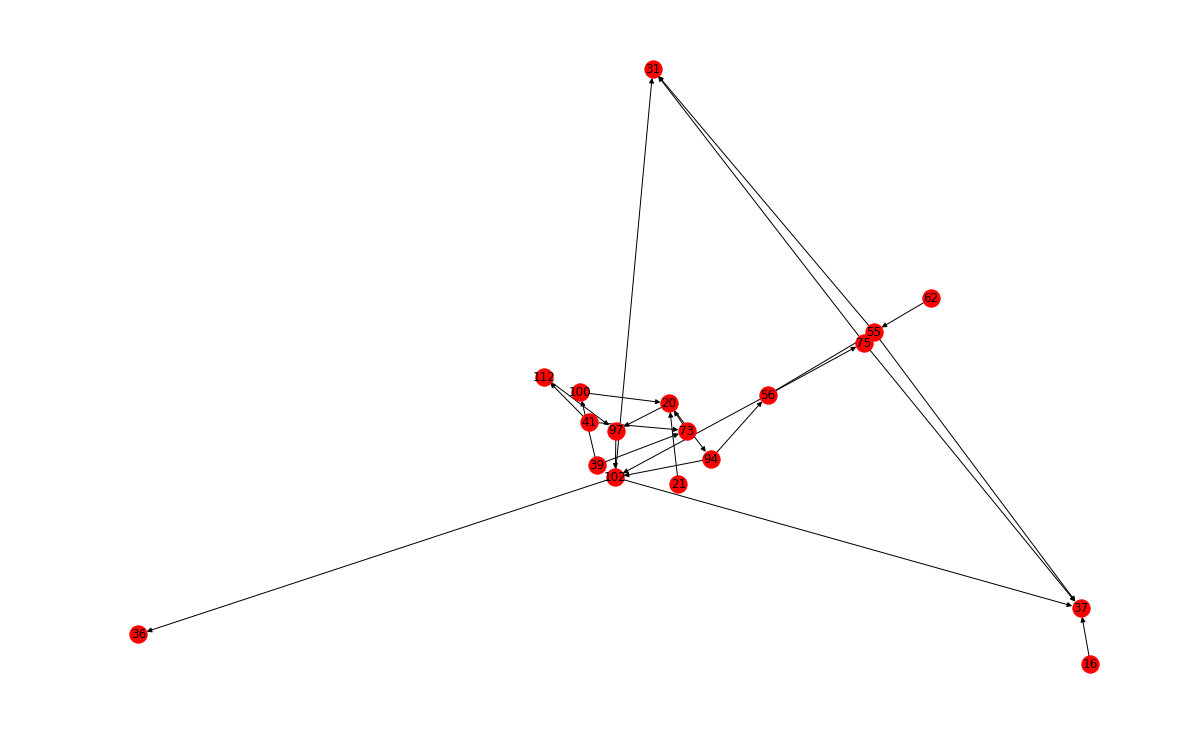

In [23]:
## 4b: Pipeline dependency

import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

# add all 18 nodes from task_ids.txt, and create edges based on relations.txt:
lst = [97,75,100,102,16,39,41,62,112,20,21,73,56,55,36,37,94,31]

map(G.add_node, lst)

# 102 depends on 97:
G.add_edge(97,102)

# 31 and 37 depend on 75
G.add_edge(75,31)
G.add_edge(75,37)

# 20 depends on 100
G.add_edge(100,20)

# 31, 36 and 37 depend on 102
G.add_edge(102,36)
G.add_edge(102,37)
G.add_edge(102,31)

# 37 depends on 16
G.add_edge(16,37)

# 73 and 100 depends on 39
G.add_edge(39,73)
G.add_edge(39,100)

# 73 and 112 depend on 41
G.add_edge(41,73)
G.add_edge(41,112)

# 55 depends on 62
G.add_edge(62,55)

# 97 depends on 112
G.add_edge(112,97)

# 94 and 97 depend on 20
G.add_edge(20,94)
G.add_edge(20,97)

# 20 depends on 21 and 73
G.add_edge(21,20)
G.add_edge(73,20)

# 102, 75, and 55 depend on 56
G.add_edge(56,102)
G.add_edge(56,75)
G.add_edge(56,55)

# 31 and 37 depends on 55
G.add_edge(55,31)
G.add_edge(55,37)

# 56 and 102 depend on 94
G.add_edge(94,56)
G.add_edge(94,102)


plt.figure(figsize=(16,10))
#nx.draw(G, edge_color='r', with_labels=True)
nx.draw(G, with_labels=True)
plt.show()